In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     

# Question and Answering

In [2]:
from transformers import (
    pipeline,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    IntervalStrategy,
    default_data_collator
)
from datasets import load_dataset
import torch
import os

In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
"""import os
import torch
import evaluate
import datasets
import collections
import transformers
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from time import perf_counter
from torch.utils.data import DataLoader
from datasets import (
    load_dataset,
    disable_progress_bar
)"""

In [35]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
batch_size = 64
tokenizer = AutoTokenizer. from_pretrained(model_ckpt)
ds_name = "covid_qa_deepset"
device = "cuda" if torch.cuda.is_available() else "cpu"
cache_dir = None

In [5]:
from datasets import load_dataset

ds = load_dataset("covid_qa_deepset", split="train")

Generating train split:   0%|          | 0/2019 [00:00<?, ? examples/s]

## Data analysis

In [6]:
ds=ds.train_test_split(test_size=0.3)

ds

DatasetDict({
    train: Dataset({
        features: ['document_id', 'context', 'question', 'is_impossible', 'id', 'answers'],
        num_rows: 1413
    })
    test: Dataset({
        features: ['document_id', 'context', 'question', 'is_impossible', 'id', 'answers'],
        num_rows: 606
    })
})

In [ ]:
print(ds["train"]["question"][2])
print(ds["train"]["answers"][2])
print(ds["train"]["context"][2])

How did  the SARS-CoV gain elevated replication and lung pathogenesis in aged mice ?
{'text': ['due to six coding genetic mutations associated with mouse adaptation.'], 'answer_start': [3229]}
No credible evidence supporting claims of the laboratory engineering of SARS-CoV-2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7054935/

SHA: 5a9154aee79901dd8fecd58b7bcd9b7351102d24

Authors: Liu, Shan-Lu; Saif, Linda J.; Weiss, Susan R.; Su, Lishan
Date: 2020-02-26
DOI: 10.1080/22221751.2020.1733440
License: cc-by

Abstract: nan

Text: The emergence and outbreak of a newly discovered acute respiratory disease in Wuhan, China, has affected greater than 40,000 people, and killed more than 1,000 as of Feb. 10, 2020. A new human coronavirus, SARS-CoV-2, was quickly identified, and the associated disease is now referred to as coronavirus disease discovered in 2019 (COVID-19) (https://globalbiodefense. com/novel-coronavirus-covid-19-portal/).

According to what has been reported [1] [2] [3] , COVID

In [7]:
import pandas as pd
df_split={split: dset.to_pandas() for split , dset in ds.flatten().items()}

for split ,df in df_split.items():
  print(f"Number of question in {split}: {df['id'].nunique()}")

Number of question in train: 1413
Number of question in test: 606


In [8]:
cols = ["document_id","question","answers.text","answers.answer_start","context"]
sampledf = df_split["train"][cols].sample(10, random_state=7)
sampledf

,document_id,question,answers.text,answers.answer_start,context
525,1719,Has AAV been studied as vectors for influenza?,[There are limited studies],[14703],Virus-Vectored Influenza Virus Vaccines\n\nhtt...
1082,2504,Why may the mechanisms of exacerbation vary c...,[due to the complex interactions between the h...,[3281],Respiratory Viral Infections in Exacerbation o...
715,2642,How many cases had no pre-existing conditions?,[five],[7889],First cases of coronavirus disease 2019 (COVID...
1356,1719,What is the added protection of NDV vector?,[providing protection against both the influen...,[24545],Virus-Vectored Influenza Virus Vaccines\n\nhtt...
1277,1660,With what have three studies correlated plasm...,"[with disease severity for HCPS and HFRS,]",[15442],Hantaviruses in the Americas and Their Role as...
536,1689,What complications are associated with CHIKV?,"[from most common to least common, include res...",[7093],Chikungunya: A Potentially Emerging Epidemic?\...
454,2459,What is the conclusion of this report?,[More studies are needed to explore this possi...,[7082],No credible evidence supporting claims of the ...
1026,2620,"As of 26 January 2020, what countries had spor...","[were reported in Thailand, Japan, Republic of...",[2574],Estimating the Unreported Number of Novel Coro...
432,1687,How do the authors suggest that ATP1A1 and PHB...,[using genetics and pharmacological inhibition...,[34177],Interactome analysis of the lymphocytic chorio...
325,2683,What is the key aim of non-pharmaceutical inte...,[reduce the effective reproduction number],[6703],Estimating the number of infections and the im...


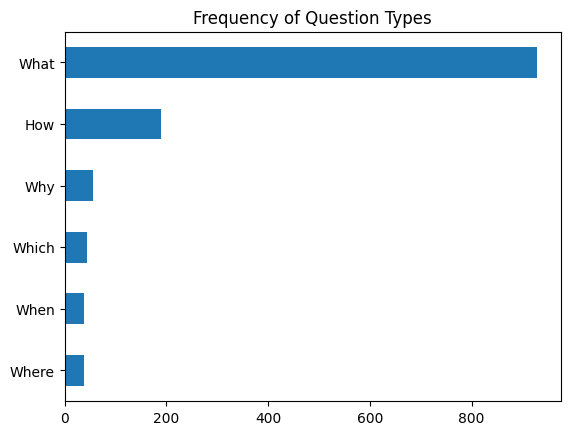

In [9]:
import matplotlib.pyplot as plt
counts ={}
question_types = ["What","How","Where","Why","Which","When"]
for q in question_types:
  counts[q]= df_split["train"]["question"].str.startswith(q).value_counts(dropna = False)[True]
pd.Series(counts).sort_values().plot.barh()
plt.title ("Frequency of Question Types")
plt.show()

In [ ]:
"""
ques =  df_split["train"]["question"][12]
context = df_split["train"]["context"][12]
inputs = tokenizer(ques,context, return_tensors="pt")

inputs

len(inputs ["input_ids"][0])
"""

10823

In [ ]:
#print(tokenizer.decode (inputs ["input_ids"][0]))

In [10]:
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
model

#with torch.no_grad(): # disabling gradient for inferencing
  #outputs = model(**inputs)

#print(outputs)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
#start_logits = outputs. start_logits
#end_logits = outputs.end_logits

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# Use plot styling from seaborn.
#sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
#plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
#input = tokenizer.encode(ques,context)
#tokens = tokenizer.convert_ids_to_tokens(input)
#print('The input has a total of {:} tokens.'.format(len(input)))


In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
#s_scores = start_logits.detach().numpy().flatten()
#e_scores = end_logits.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.

#token_labels = []
#for (i, token) in enumerate(tokens):
    #token_labels.append('{:} - {:>2}'.format(token, i))
#print(len(token_labels))

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
#ax = sns.barplot(x=token_labels, y=s_scores)

# Turn the xlabels vertical.
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
#ax.grid(True)

#plt.title('Start Word Scores')

#plt.show()

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
 #ax = sns.barplot(x=token_labels, y=e_scores)

# Turn the xlabels vertical.
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
#ax.grid(True)

#plt.title('End Word Scores')

#plt.show()

In [ ]:
#import torch
#start_idx = torch.argmax(start_logits)
#end_idx = torch.argmax(end_logits)+1
#answer_span = inputs["input_ids"][0][start_idx: end_idx]
#answer = tokenizer.decode(answer_span)
#print(f"Question: {ques}")
#print(f"Answer:  { answer}")

In [ ]:
#from transformers import pipeline
#pipe = pipeline ("question-answering", model=model, tokenizer=tokenizer,handle_impossible_answer= True)
#pipe(question=ques, context=context , tokp=3)

##Context lenght is more than token

In [ ]:
#for i, example in enumerate(ds["train"]):
    #if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        #break
#print(i)
#example = ds["train"][i]
#example

In [ ]:
example = ds["train"][5]

print(example["question"])

len(tokenizer(example["question"], example["context"])["input_ids"])

How many deaths each year are caused by gastroenteritis?


4299

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
tokenized_example = tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second" ,stride =doc_stride)
print(tokenized_example)
len(tokenized_example["input_ids"])

{'input_ids': [101, 2129, 2116, 6677, 2169, 2095, 2024, 3303, 2011, 3806, 13181, 29110, 13706, 1029, 102, 18191, 4786, 3806, 13181, 29110, 13706, 1024, 1996, 2124, 1010, 1996, 2047, 1998, 2216, 3458, 16770, 1024, 1013, 1013, 7479, 1012, 13316, 5638, 1012, 17953, 2213, 1012, 9152, 2232, 1012, 18079, 1013, 7610, 2278, 1013, 4790, 1013, 7610, 2278, 22610, 2581, 2575, 16147, 2581, 1013, 21146, 1024, 1042, 2581, 2497, 14142, 4402, 2620, 2683, 2581, 23352, 9818, 2620, 23833, 2692, 2581, 9468, 2575, 9818, 2620, 2581, 7959, 2497, 28154, 22022, 2497, 22610, 2575, 17788, 2546, 6048, 1024, 15068, 3207, 14163, 23500, 8950, 1010, 19021, 1038, 1012, 1025, 3158, 4315, 7570, 5937, 1010, 22393, 3058, 1024, 2355, 1011, 6185, 1011, 2539, 9193, 1024, 2184, 1012, 28977, 2692, 1013, 15754, 2692, 28332, 20958, 6105, 1024, 10507, 1011, 2011, 10061, 1024, 1996, 2862, 1997, 3728, 3603, 3806, 13181, 18447, 19126, 18191, 2003, 9186, 5901, 1012, 3251, 2122, 6074, 2024, 2941, 2920, 1999, 1037, 4295, 2107, 2004, 229

384

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])


#offsets mapping returned by the tokenizer, which gives us a tuple indicating each sub token's start and end position relative to the original token it was split from. For special tokens, offset mapping's start and end position will both be set to 0.


[(0, 0), (0, 3), (4, 8), (9, 15), (16, 20), (21, 25), (26, 29), (30, 36), (37, 39), (40, 43), (43, 46), (46, 51), (51, 55), (55, 56), (0, 0), (0, 7), (8, 15), (16, 19), (19, 22), (22, 27), (27, 31), (31, 32), (33, 36), (37, 42), (42, 43), (44, 47), (48, 51), (52, 55), (56, 61), (62, 68), (70, 75), (75, 76), (76, 77), (77, 78), (78, 81), (81, 82), (82, 84), (84, 86), (86, 87), (87, 89), (89, 90), (90, 91), (91, 93), (93, 94), (94, 95), (95, 98), (98, 99), (99, 101), (101, 102), (102, 103), (103, 111), (111, 112), (112, 114), (114, 115), (115, 117), (117, 118), (118, 119), (119, 121), (121, 122), (122, 123), (125, 128), (128, 129), (130, 131), (131, 132), (132, 133), (133, 135), (135, 137), (137, 138), (138, 139), (139, 140), (140, 142), (142, 144), (144, 145), (145, 147), (147, 148), (148, 149), (149, 151), (151, 152), (152, 154), (154, 155), (155, 156), (156, 158), (158, 159), (159, 161), (161, 163), (163, 164), (164, 166), (166, 167), (167, 169), (169, 170), (172, 179), (179, 180), (1

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 384,
 219]

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many deaths each year are caused by gastroenteritis? [SEP] viruses causing gastroenteritis : the known, the new and those beyond https : / / www. ncbi. nlm. nih. gov / pmc / articles / pmc4776197 / sha : f7b30ee89775bc82607cc6bc87feb5934b47625f authors : oude munnink, bas b. ; van der hoek, lia date : 2016 - 02 - 19 doi : 10. 3390 / v8020042 license : cc - by abstract : the list of recently discovered gastrointestinal viruses is expanding rapidly. whether these agents are actually involved in a disease such as diarrhea is the essential question, yet difficult to answer. in this review a summary of all viruses found in diarrhea is presented, together with the current knowledge about their connection to disease. text : the gastrointestinal tract is a vulnerable organ for infections as there is constant contact with the outside, mainly via the oral route. inflammation of the stomach and the intestines ( gastroenteritis ) can cause nausea, vomiting and diarrhea. gastroenteritis i

In [ ]:
#first_token_id = tokenized_example["input_ids"][0][1]
#print(first_token_id)
#offsets = tokenized_example["offset_mapping"][0][1]
#print(offsets)
#print(tokenizer.convert_ids_to_tokens([first_token_id])[0], ques[offsets[0]:offsets[1]])

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

"""
Last thing we'll mention is the sequence_ids attribute. When feeding pairs of input to a tokenizer, we can use it to distinguish first and second portion of a given sentence. In question and answering this will be helpful for identifying whether the predicted answer's start and end position falls inside context portion of a given document, instead of question portion. If we look at a sample output, we'll notice that special tokens will be mapped to None, whereas our context, which is passed as the second part of our paired input will receive a value of 1.
"""

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

"\nLast thing we'll mention is the sequence_ids attribute. When feeding pairs of input to a tokenizer, we can use it to distinguish first and second portion of a given sentence. In question and answering this will be helpful for identifying whether the predicted answer's start and end position falls inside context portion of a given document, instead of question portion. If we look at a sample output, we'll notice that special tokens will be mapped to None, whereas our context, which is passed as the second part of our paired input will receive a value of 1.\n"

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

print(answers)
print(answers["text"][0])
print(start_char)
print(end_char)

{'text': ['two to three million'], 'answer_start': [919]}
two to three million
919
939


In [ ]:
# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1
print(token_start_index)

15


In [ ]:
# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1
print(token_end_index )

382


In [ ]:
# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

259 262


In [ ]:
#print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
#print(answers["text"][0])

In [ ]:
"""
examples = [    "We are going to split this sentence",
    "This sentence is longer, we are also going to split it"
]
tokenized = tokenizer(
    examples,
    truncation=True,
    return_overflowing_tokens=True,
    max_length=6,
    stride=2
)
print("number of examples: ", len(examples))
print("number of tokenized features: ", len(tokenized["input_ids"]))
tokenized
"""

'\nexamples = [    "We are going to split this sentence",\n    "This sentence is longer, we are also going to split it"\n]\ntokenized = tokenizer(\n    examples,\n    truncation=True,\n    return_overflowing_tokens=True,\n    max_length=6,\n    stride=2\n)\nprint("number of examples: ", len(examples))\nprint("number of tokenized features: ", len(tokenized["input_ids"]))\ntokenized\n'

In [ ]:
# if we print out the batched input ids, we'll see each one
# of our sentences has been split to multiple chunks/features
#for input_id, sample_mapping in zip(tokenized["input_ids"], tokenized["overflow_to_sample_mapping"]):
    #chunk = tokenizer.decode(input_id)
    #print("Chunk: ", chunk)
    #print("Orignal input: ", examples[sample_mapping])

## xyz

Upon introducing these advanced tokenizer usages, the next few code cell showcase how to put them in use and creates a function for preprocessing our question answer dataset into a format that's suited for downstream modeling. Note:

When performing truncation, we should only truncate the context, never the question. Configured via truncation="only_second"
Given that we split a single document into several chunks, it can happen that a given chunk doesn't contain a valid answer, in this case, we will set question answer task's label, start_position and end_position, to index 0 (special token [CLS]'s index).
We'll be padding every feature to maximum length, as most of the context will be reaching that threshold, there's no real benefit of performing dynamic padding.

In [11]:
pad_on_right = tokenizer.padding_side == "right"
max_length =384
doc_stride =128

In [12]:
def prepare_qa_train(examples):
    """Prepare training data, input features plus label for question answering dataset."""
    answers = examples["answers"]
    examples["question"] = [question.strip() for question in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep overflows using a stride.
    # This results in one example potentially generating several features when a context is
    # long, each of those features having a context that overlaps a bit the previous
    # feature's context to prevent chopping off answer span.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        stride=doc_stride,
        padding="max_length"
    )
    sample_mapping = tokenized_examples["overflow_to_sample_mapping"]
    offset_mapping = tokenized_examples["offset_mapping"]

     # We will label impossible answers with CLS token's index.
    cls_index = 0

    # start_positions and end_positions will be the labels for extractive question answering
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    for i, offset in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]

        sample_index = sample_mapping[i]
        answer = answers[sample_index]

        # if no answers are given, set CLS index as answer
        if len(answer["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

            sequence_ids = tokenized_examples.sequence_ids(i)

            # find the context's corresponding start and end token index
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # if answer is within the context offset, move the token_start_index and token_end_index
            # to two ends of the answer else label it with cls index
            offset_start_char = offset[token_start_index][0]
            offset_end_char = offset[token_end_index][1]
            if offset_start_char <= start_char and offset_end_char >= end_char:
                while token_start_index < len(offset) and offset[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_position = token_start_index - 1

                while offset[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_position = token_end_index + 1

                tokenized_examples["start_positions"].append(start_position)
                tokenized_examples["end_positions"].append(end_position)
            else:
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)

    return tokenized_examples

In [ ]:
# Ref: https://keras.io/examples/nlp/question_answering/ (Taken the example from)
"""

def prepare_ds_features(ds_data):
    #Remove left whitespace
    ds_data["question"] = [q.lstrip() for q in ds_data["question"]]

    # Tokenize our ds_data with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_ds_data = tokenizer(
        ds_data["question" if pad_on_right else "context"],
        ds_data["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    # Looks like [0,1,2,2,2,3,4,5,5...] - Here 2nd input pair has been split in 3 parts

    sample_mapping = tokenized_ds_data.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    # Looks like [[(0,0),(0,3),(3,4)...] ] - Contains the actual start indices and end indices for each word in the input.

    offset_mapping = tokenized_ds_data.pop("offset_mapping")

    # Let's label those ds_data!
    tokenized_ds_data["start_positions"] = []
    tokenized_ds_data["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_ds_data["input_ids"][i]
        print(f" input ids are {input_ids}")
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_ds_data.sequence_ids(i)
        print(f" sequence ids are {sequence_ids}")


        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        print(sample_index)
        answers = ds_data["answers"][sample_index]

        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_ds_data["start_positions"].append(cls_index)
            tokenized_ds_data["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_ds_data["start_positions"].append(cls_index)
                tokenized_ds_data["end_positions"].append(cls_index)
                print(f"{i} answer out of span")
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_ds_data["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_ds_data["end_positions"].append(token_end_index + 1)
                print(tokenized_ds_data)
    return tokenized_ds_data

    """

In [14]:
examples = ds["train"][50:51]
answers = examples["answers"]
answers[0]["text"][0]

'Western blot'

In [15]:
tokenized_example = tokenizer(
    examples["question"],
    examples["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
i=0
for x in tokenized_example["input_ids"]:
    print(i)
    i=i+1
    print(tokenizer.decode(x))

0
[CLS] what laboratory test can be used to monitor protein expression? [SEP] venezuelan equine encephalitis virus induces apoptosis through the unfolded protein response activation of egr1 https : / / www. ncbi. nlm. nih. gov / pmc / articles / pmc4794670 / sha : f4aa788ab898b28b00ee103e4d4ab24a2c684caf authors : baer, alan ; lundberg, lindsay ; swales, danielle ; waybright, nicole ; pinkham, chelsea ; dinman, jonathan d. ; jacobs, jonathan l. ; kehn - hall, kylene date : 2016 - 03 - 11 doi : 10. 1128 / jvi. 02827 - 15 license : cc - by abstract : venezuelan equine encephalitis virus ( veev ) is a previously weaponized arthropod - borne virus responsible for causing acute and fatal encephalitis in animal and human hosts. the increased circulation and spread in the americas of veev and other encephalitic arboviruses, such as eastern equine encephalitis virus and west nile virus, underscore the need for research aimed at characterizing the pathogenesis of viral encephalomyelitis for the

In [16]:
examples = ds["train"][50:51]
answers = examples["answers"]

tokenized_examples = prepare_qa_train(examples)

start_positions = tokenized_examples["start_positions"]
end_positions = tokenized_examples["end_positions"]
for i, input_ids in enumerate(tokenized_examples["input_ids"]):
    start = start_positions[i]
    end = end_positions[i] + 1
    print(i)
    string = tokenizer.decode(input_ids[start:end])
    print("preprocessing answer:", string)
print("expected answer:", answers[0]["text"][0])



0
preprocessing answer: [CLS]
1
preprocessing answer: [CLS]
2
preprocessing answer: [CLS]
3
preprocessing answer: [CLS]
4
preprocessing answer: [CLS]
5
preprocessing answer: [CLS]
6
preprocessing answer: [CLS]
7
preprocessing answer: [CLS]
8
preprocessing answer: [CLS]
9
preprocessing answer: [CLS]
10
preprocessing answer: [CLS]
11
preprocessing answer: [CLS]
12
preprocessing answer: [CLS]
13
preprocessing answer: [CLS]
14
preprocessing answer: [CLS]
15
preprocessing answer: [CLS]
16
preprocessing answer: [CLS]
17
preprocessing answer: [CLS]
18
preprocessing answer: [CLS]
19
preprocessing answer: [CLS]
20
preprocessing answer: [CLS]
21
preprocessing answer: [CLS]
22
preprocessing answer: [CLS]
23
preprocessing answer: [CLS]
24
preprocessing answer: [CLS]
25
preprocessing answer: [CLS]
26
preprocessing answer: [CLS]
27
preprocessing answer: [CLS]
28
preprocessing answer: [CLS]
29
preprocessing answer: [CLS]
30
preprocessing answer: western blot
31
preprocessing answer: [CLS]
32
preproce

In [17]:
tokenized_datasets = ds.map(
    prepare_qa_train,
    batched=True,
    remove_columns=ds["train"].column_names,
    num_proc=8
)
tokenized_datasets

Map (num_proc=8):   0%|          | 0/1413 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/606 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions'],
        num_rows: 43457
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions'],
        num_rows: 18616
    })
})

##Fine tuning

In [18]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install accelerate>=0.21.0

In [37]:
model_name = model_ckpt.split("/")[-1]
fine_tuned_model_checkpoint = f"{model_name}-fine_tuned-{ds_name}"

if os.path.isdir(fine_tuned_model_checkpoint):
    do_train = False
    model = AutoModelForQuestionAnswering.from_pretrained(fine_tuned_model_checkpoint, cache_dir=cache_dir)
else:
    do_train = True
    model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt, cache_dir=cache_dir)

print(fine_tuned_model_checkpoint)
args = TrainingArguments(
    fine_tuned_model_checkpoint,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_steps=1,
    save_strategy=IntervalStrategy.EPOCH,
    save_total_limit=2,
    do_train=do_train

)


distilbert-base-uncased-fine_tuned-covid_qa_deepset


In [21]:
data_collator = default_data_collator

In [22]:
len(tokenized_datasets["test"])

18616

In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
if trainer.args.do_train:
    train_output = trainer.train()
    # saving the model which allows us to leverage
    # .from_pretrained(model_path)
    trainer.save_model(fine_tuned_model_checkpoint)

Epoch,Training Loss,Validation Loss
1,0.003100,0.332582
2,0.001400,0.245005
3,0.004100,0.250637


##Evaluation of Model

In [38]:
import torch

for batch in trainer.get_eval_dataloader():
    break
print(batch)
print(len(batch))
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()


AttributeError: 'AcceleratorState' object has no attribute 'distributed_type'

In [26]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

In [27]:
output.start_logits[54]

tensor([ 4.8203, -6.0820, -6.2656, -6.1602, -6.3242, -6.4180, -6.1680, -6.5352,
        -6.1445, -6.4297, -6.6133, -6.6875, -6.6367, -7.1484, -6.5273, -6.4297,
        -6.5273, -5.3750, -6.3555, -6.5156, -7.1602, -6.9180, -6.3594, -6.5664,
        -6.1133, -4.2344, -3.2227, -5.8516, -6.7344, -6.1953, -6.9805, -6.6875,
        -6.5195, -6.6758, -6.4453, -6.3789, -7.3438, -7.1641, -6.4492, -6.4219,
        -4.8633, -3.1504, -6.2461, -6.5430, -6.5117, -6.3789, -6.5391, -7.1406,
        -6.7266, -6.7969, -6.3906, -6.1289, -6.4102, -7.1680, -7.1133, -7.0391,
        -6.9219, -6.7422, -6.4883, -6.6953, -7.2695, -5.7617, -5.5938, -5.6445,
        -6.0742, -5.9570, -6.3789, -6.4805, -6.2539, -6.5039, -6.8672, -7.5625,
        -6.8086, -5.9844, -6.7109, -6.5742, -6.8633, -6.8086, -6.8125, -5.3828,
        -3.5215, -4.0938, -6.0781, -6.8711, -6.3047, -5.9805, -5.1211, -6.3906,
        -7.0781, -6.1016, -7.2227, -6.3359, -6.1875, -6.0430, -5.9922, -6.5078,
        -6.4297, -5.9375, -6.6133, -6.85

In [28]:
output.start_logits[1].argmax()

tensor(0, device='cuda:0')

In [46]:
ds["test"][24]

{'document_id': 1741,
 'context': 'MERS coronavirus: diagnostics, epidemiology and transmission\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC4687373/\n\nSHA: f6fcf1a99cbd073c5821d1c4ffa3f2c6daf8ae29\n\nAuthors: Mackay, Ian M.; Arden, Katherine E.\nDate: 2015-12-22\nDOI: 10.1186/s12985-015-0439-5\nLicense: cc-by\n\nAbstract: The first known cases of Middle East respiratory syndrome (MERS), associated with infection by a novel coronavirus (CoV), occurred in 2012 in Jordan but were reported retrospectively. The case first to be publicly reported was from Jeddah, in the Kingdom of Saudi Arabia (KSA). Since then, MERS-CoV sequences have been found in a bat and in many dromedary camels (DC). MERS-CoV is enzootic in DC across the Arabian Peninsula and in parts of Africa, causing mild upper respiratory tract illness in its camel reservoir and sporadic, but relatively rare human infections. Precisely how virus transmits to humans remains unknown but close and lengthy exposure appears to be a

In [40]:
fine_tuned_model_checkpoint

'distilbert-base-uncased-fine_tuned-covid_qa_deepset'

In [45]:
example = ds["test"][24]
qa_pipeline = pipeline(
    "question-answering",
    model=fine_tuned_model_checkpoint,
    tokenizer=fine_tuned_model_checkpoint
)

output = qa_pipeline({
    "question": example["question"],
    "context": example["context"]
})
answer_text = example["answers"]["text"][0]
print("output answer matches expected answer: ", output["answer"] == answer_text)
output

output answer matches expected answer:  False


{'score': 0.07641510665416718,
 'start': 52035,
 'end': 52082,
 'answer': 'only human-derived MERS-CoV genomes from Jordan'}

# Not Required

In [ ]:
n_best_size = 20

In [ ]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [ ]:
valid_answers

[{'score': 11.136719, 'text': ''},
 {'score': 7.6171875, 'text': ''},
 {'score': 7.4121094, 'text': ''},
 {'score': 7.303711, 'text': ''},
 {'score': 6.7753906, 'text': ''},
 {'score': 6.723633, 'text': ''},
 {'score': 6.5117188, 'text': ''},
 {'score': 6.3847656, 'text': ''},
 {'score': 6.2978516, 'text': ''},
 {'score': 6.114258, 'text': ''},
 {'score': 6.1035156, 'text': ''},
 {'score': 6.073242, 'text': ''},
 {'score': 5.9692383, 'text': ''},
 {'score': 5.760742, 'text': ''},
 {'score': 5.751709, 'text': ''},
 {'score': 5.6032104, 'text': ''},
 {'score': 5.5924683, 'text': ''},
 {'score': 5.5838013, 'text': ''},
 {'score': 5.514618, 'text': ''},
 {'score': 5.503296, 'text': ''},
 {'score': 4.9492188, 'text': ''},
 {'score': 4.7441406, 'text': ''},
 {'score': 4.635742, 'text': ''},
 {'score': 4.107422, 'text': ''},
 {'score': 4.055664, 'text': ''},
 {'score': 3.84375, 'text': ''},
 {'score': 3.7167969, 'text': ''},
 {'score': 3.6298828, 'text': ''},
 {'score': 3.446289, 'text': ''},

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
final_predictions = postprocess_qa_predictions(ds["validation"], validation_features, raw_predictions.predictions)

Post-processing 255 example predictions split into 412 features.


  0%|          | 0/255 [00:00<?, ?it/s]

In [ ]:
validation_features = ds["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=ds["validation"].column_names
)

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

In [ ]:
raw_predictions = trainer.predict(validation_features)
raw_predictions.predictions


(array([[ 4.8945312, -3.2148438, -3.8222656, ..., -4.6171875, -4.3515625,
         -2.3964844],
        [ 5.4765625, -2.9921875, -3.7363281, ..., -4.8320312, -4.7265625,
         -4.7304688],
        [ 4.9648438, -1.4609375, -2.6386719, ..., -3.9648438, -3.9746094,
         -3.8476562],
        ...,
        [ 5.4375   , -3.5566406, -3.9160156, ..., -4.390625 , -4.7070312,
         -2.4980469],
        [ 5.5664062, -3.3300781, -3.7988281, ..., -4.8046875, -4.71875  ,
         -4.71875  ],
        [ 5.5625   , -2.8359375, -3.6894531, ..., -4.6210938, -4.5703125,
         -4.5195312]], dtype=float32),
 array([[ 4.3515625, -4.3710938, -4.6484375, ..., -3.7128906, -2.5117188,
         -2.3339844],
        [ 5.1992188, -4.40625  , -4.671875 , ..., -5.2070312, -5.234375 ,
         -5.3242188],
        [ 4.7695312, -2.3847656, -3.6796875, ..., -3.8144531, -4.3984375,
         -4.1523438],
        ...,
        [ 5.546875 , -4.5507812, -4.6875   , ..., -3.2226562, -4.546875 ,
         -2.3828125

In [ ]:
def postprocess_qa_predictions(
    examples,
    features,
    raw_predictions,
    n_best_size = 20,
    max_answer_length = 30,
    no_answer = False
):
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    all_start_logits, all_end_logits = raw_predictions

    # build a dictionary that stores examples to features/chunks mapping
    # key : example, value : list of features
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    cls_index = 0
    predictions = collections.OrderedDict()

    # for each example, loop through all its features/chunks for finding the best one
    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]

        min_null_score = None
        valid_answers = []
        context = example["context"]
        for feature_index in feature_indices:
            # model prediction for this feature
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            offset_mapping = features[feature_index]["offset_mapping"]

            # update minimum null prediction's score
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # loop through all possibilities for `n_best_size` start and end logits.
            start_indexes = np.argsort(start_logits)[-1:-n_best_size - 1:-1].tolist()
            end_indexes = np.argsort(end_logits)[-1:-n_best_size - 1:-1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because indices
                    # are out of bounds or correspond to input_ids that
                    # are not part of the context section.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or len(offset_mapping[start_index]) < 2
                        or offset_mapping[end_index] is None
                        or len(offset_mapping[end_index]) < 2
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "text": context[start_char:end_char],
                            "score": start_logits[start_index] + end_logits[end_index]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = max(valid_answers, key=lambda x: x["score"])
        else:
            # In the very rare edge case we have not a single non-null prediction,
            # we create a fake prediction to avoid failure.
            best_answer = {"text": "", "score": 0.0}

        example_id = example["id"]
        if no_answer:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example_id] = answer
        else:
            predictions[example_id] = best_answer["text"]

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(
    ds["validation"],
    validation_features,
    raw_predictions.predictions
)
print("output answer matches expected answer: ", final_predictions[example["id"]] == answer_text)

Post-processing 255 example predictions split into 412 features.


  0%|          | 0/255 [00:00<?, ?it/s]

output answer matches expected answer:  True


In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

In [ ]:
squad_metric = evaluate.load('squad', cache_dir=cache_dir)
squad_metric

formatted_predictions = [
    {"id": example_id, "prediction_text": answer}
    for example_id, answer in final_predictions.items()
]
references = [{"id": example["id"], "answers": example["answers"]} for example in ds["validation"]]
squad_metric.compute(predictions=formatted_predictions, references=references)

EvaluationModule(name: "squad", module_type: "metric", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD scores (F1 and EM).
Args:
    predictions: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair as given in the references (see below)
        - 'prediction_text': the text of the answer
    references: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair (see above),
        - 'answers': a Dict in the SQuAD dataset format
            {
                'text': list of possible texts for the answer, as a list of strings
                'answer_start': list of start positions for 